# 생성적 적대 신경망(GAN) : 이미지 생성 모델
* 가짜 이미지를 생성하는 생성자와 가짜/진짜 이미지를 분류하는 판별자의 경쟁을 통해 진짜같은 가짜 이미지 생성

In [1]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.preprocessing import image
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, LeakyReLU, UpSampling2D, ZeroPadding2D, Input, Reshape, Activation
from keras.models import Model, Sequential
from keras.utils import np_utils
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 판별자 sample
# 일련의 합성곱층 --> 시그모이드 함수(가짜 : 0, 진짜 : 1) --> 진짜 이미지일 확률 도출

def discriminator_model():
  
  discriminator = Sequential()
  # Conv_1
  discriminator.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(28,28,1), padding='same'))
  discriminator.add(LeakyReLU(alpha=0.2))
  
  discriminator.add(Dropout(0.25))
  
  # Conv_2
  discriminator.add(Conv2D(64,kernel_size=3, strides=2, padding='same'))
  discriminator.add(ZeroPadding2D(padding=((0,1), (0,1))))  # padding 적용 X
  discriminator.add(BatchNormalization(momentum=0.8))
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dropout(0.25))

  # Conv_3
  discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
  discriminator.add(BatchNormalization(momentum=0.8))
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dropout(0.25))

  # Conv_4
  discriminator.add(Conv2D(256, kernel_size=3, strides=1, padding='same'))
  discriminator.add(BatchNormalization(momentum=0.8))
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dropout(0.25))
  
  # FC_layer
  discriminator.add(Flatten())
  discriminator.add(Dense(1, activation='sigmoid'))  # sigmoid function
  
  print(discriminator.summary())

  img_shape=(28,28,1)
  img = Input(shape=img_shape)
  probability = discriminator(img)

  return Model(inputs=img, outputs=probability)

In [3]:
# upsampling 예시

X = np.asarray([[[1,2],
                 [3,4]]]
               )  # 2X2

print(X, '\n')
print(X.shape, '\n')

X = X.reshape(1,2,2,1)   # 채널(깊이) 추가

model = Sequential()
model.add(UpSampling2D(input_shape=(2,2,1)))    # 기존 X의 개별 요소를 2X2로 늘리는 UpSampling 수행

yhat = model.predict(X)
yhat = yhat.reshape((4,4))
print(yhat,'\n')
print(yhat.shape)

[[[1 2]
  [3 4]]] 

(1, 2, 2) 

[[1. 1. 2. 2.]
 [1. 1. 2. 2.]
 [3. 3. 4. 4.]
 [3. 3. 4. 4.]] 

(4, 4)


In [4]:
# 생성자 sample
# 무작위 노이즈 값이 들어간 입력벡터 --> 텐서(너비, 높이, 깊이)로 변환하고 변환된 텐서를 feature map 취급
# --> 훈련 데이터와 비슷한 크기가 될 때까지 upsampling 반복

def generator_model():
  generator = Sequential()

  generator.add(Dense(128*7*7, activation='relu', input_dim=100)) # 뉴런수가 128*7*7인 Fc_layer 
  generator.add(Reshape((7,7,128)))   # 이미지 텐서 모양을 7*7*128로 변환
  generator.add(UpSampling2D(size=(2,2)))   # (14,14,128)
  
  # Conv_1
  generator.add(Conv2D(128,kernel_size=3, padding='same'))
  generator.add(BatchNormalization(momentum=0.8))
  generator.add(Activation("relu"))
  generator.add(UpSampling2D(size=(2,2)))    # (28,28,128) --> mnist이미지와 같은 28,28 크기가 되었으므로 더는 UpSampling하지 않는다

  # Conv_2
  generator.add(Conv2D(64, kernel_size=3, padding='same'))   # (28,28,64)
  generator.add(BatchNormalization(momentum=0.8))
  generator.add(Activation("relu"))

  # Conv_3
  generator.add(Conv2D(1, kernel_size=3, padding='same'))   # (28,28,1)  --> 회색조 mnist 숫자 이미지이므로
  generator.add(Activation("relu"))  # (28,28,1)
  generator.summary()

  noise = Input(shape=(100,))  # 1차원 벡터 형태 --> 모델을 거치면서 (7,7,128)형태로 변환 후 Conv_1,2,3 거침
  fake_image = generator(noise)
  return Model(noise, fake_image)

In [5]:
# 판별자 및 생성자의 학습
# 판별자는 그 자체로 학습이 가능하지만,
# 생성자는 단독으로 학습 불가능 --> 판별자와 같이 학습되어야함!  --> 통합 신경망 구성
# 단, 생성자 모델을 학습할 때는 판별자 모델의 가중치를 freeze --> 생성자 모델의 손실함수가 이끄는 방향으로 판별자 모델의 가중치도 같이 수정되면 가짜 이미지를 진짜로 판정하는 경향을 보임

# 통합 신경망
generator = generator_model()
z = Input(shape=(100,))
image = generator(z)

discriminator = discriminator_model()

discriminator.trainable = False
valid = discriminator(image)
combined = Model(z, valid)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_1 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       147584    
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 128)      512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 14, 14, 128)      

In [6]:
# 실습 : fashion_MNIST 데이터셋 (클래스0~9)

from __future__ import print_function, division

from keras.datasets import fashion_mnist


# load_data
(training_data, _), (_, _) = fashion_mnist.load_data()

X_train = training_data = training_data / 127.5 - 1.
X_train = np.expand_dims(X_train, axis=3)
print(X_train.shape)  # (60000, 28, 28, 1)

4431872/4422102 [==============================] - 0s 0us/step
(60000, 28, 28, 1)


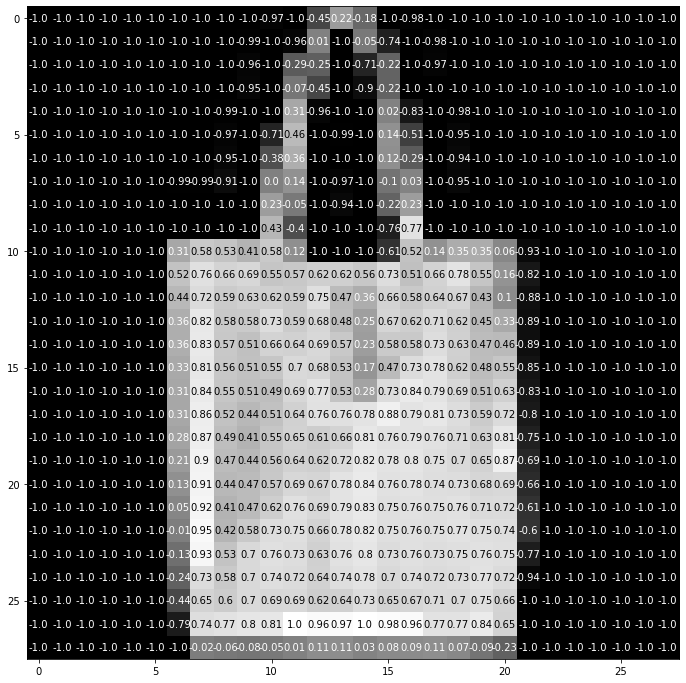

In [7]:
# visualize_sample_data  with  pixels

def visualize_input(img, ax):
  ax.imshow(img, cmap='gray')
  width, height = img.shape
  thresh = img.max()/2.5
  
  for x in range(width):
      for y in range(height):
          ax.annotate(str(round(img[x][y],2)), xy=(y,x),
                      horizontalalignment='center',
                      verticalalignment='center',
                      color='white' if img[x][y]<thresh else 'black'
                      )

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
visualize_input(training_data[3343], ax)

In [9]:
from keras.backend import batch_dot
# 생성자 모델

kargs = {'dense' : 128 * 7 * 7, 'reshape' : (7,7,128), 
         'num_filters_1' : 128, 'num_filters_2' : 64, 'num_filters_3' : 1,
         'kernel_size' : 3, 'momentum' : 0.8}

def build_generator_1(**kargs):

  generator = Sequential()

  generator.add(Dense(kargs['dense'], activation='relu', input_dim=latent_dim))
  generator.add(Reshape(kargs['reshape']))
  generator.add(UpSampling2D())   # (14,14,128)

  # conv_1
  generator.add(Conv2D(kargs['num_filters_1'], kernel_size=kargs['kernel_size'], padding='same'))
  generator.add(BatchNormalization(momentum=kargs['momentum']))
  generator.add(Activation('relu'))
  generator.add(UpSampling2D())  # (28,28,128)

  # conv_2
  generator.add(Conv2D(kargs['num_filters_2'], kernel_size=kargs['kernel_size'], padding='same'))
  generator.add(BatchNormalization(momentum=kargs['momentum']))   # (28,28,64)
  generator.add(Activation('relu'))


  # conv_3
  generator.add(Conv2D(kargs['num_filters_3'], kernel_size=kargs['kernel_size'], padding='same')) # (28,28,1)
  generator.add(Activation('tanh'))
  generator.summary()

  
  noise = Input(shape=(100, ))
  fake_image = generator(noise)

  return Model(inputs=noise, outputs=fake_image)




# 판별자 모델 
kargs_2 = {'num_filters' : 32, 'kernel_size' : 3, 'strides' : 2, 
           'momentum' : 0.8, 'alpha' : 0.2, 'dropout_rate' : 0.25,
           'dense' : 1}
def build_discriminator_1(**kargs_2):

  discriminator = Sequential()

  # conv_1
  discriminator.add(Conv2D(kargs_2['num_filters'], kernel_size=kargs_2['kernel_size'], strides=kargs_2['strides'], 
                           input_shape=(28,28,1), padding='same'))
  discriminator.add(LeakyReLU(alpha=kargs_2['alpha']))
  discriminator.add(Dropout(kargs_2['dropout_rate']))

  # conv_2
  discriminator.add(Conv2D(kargs_2['num_filters'] * 2, kernel_size=kargs_2['kernel_size'], strides=kargs_2['strides'], padding='same'))
  discriminator.add(ZeroPadding2D(padding=((0,1), (0,1))))
  discriminator.add(BatchNormalization(momentum=kargs_2['momentum']))
  discriminator.add(LeakyReLU(alpha=kargs_2['alpha']))
  discriminator.add(Dropout(kargs_2['dropout_rate']))

  # conv_3
  discriminator.add(Conv2D(kargs_2['num_filters'] * 4, kernel_size=kargs_2['kernel_size'], strides=kargs_2['strides'], padding='same'))
  discriminator.add(BatchNormalization(momentum=kargs_2['momentum']))
  discriminator.add(LeakyReLU(alpha=kargs_2['alpha']))
  discriminator.add(Dropout(kargs_2['dropout_rate']))

  # conv_4
  discriminator.add(Conv2D(kargs_2['num_filters'] * 8, kernel_size=kargs_2['kernel_size'], strides=1, padding='same'))
  discriminator.add(BatchNormalization(momentum=kargs_2['momentum']))
  discriminator.add(LeakyReLU(alpha=kargs_2['alpha']))
  discriminator.add(Dropout(kargs_2['dropout_rate']))

  # FC_layer
  discriminator.add(Flatten())
  discriminator.add(Dense(kargs_2['dense'], activation='sigmoid'))
  discriminator.summary()
  

  img = Input(shape=(28,28,1))
  probs = discriminator(img)

  return Model(inputs=img, outputs=probs)

In [10]:
# 통합 신경망 구성
img_shape = (28,28,1)
channels = 1
latent_dim = 100

discriminator = build_discriminator_1(**kargs_2)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['acc'])

discriminator.trainable = False    # 생성자 모델 학습 중 판별자 가중치 freeze

generator = build_generator_1(**kargs)

z = Input(shape=(100, ))
img = generator(z)

valid = discriminator(img)  # 판별자 모델은 생성자가 생성한 이미지(img)를 진짜인지 가짜인지 판별

combined = Model(inputs=z, outputs=valid)
combined.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['acc'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 14, 14, 32)        320       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 14, 14, 32)        0         
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 8, 8, 64)         0         
 ng2D)                                                           
                                                                 
 batch_normalization_5 (Batc  (None, 8, 8, 64)         256       
 hNormalization)                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [11]:
# 생성된 이미지 저장
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, latent_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)


# 모델 학습
def train(epochs, batch_size=128, save_interval=50):

  # 정답 데이터
  valid = np.ones((batch_size, 1))
  fake = np.zeros((batch_size,1))

  
  for epoch in range(epochs):
    
    # X_train 이미지 데이터 중 일부 랜덤추출
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    # noise 생성 & noise 데이터로 새 이미지들 일괄 생성
    noise = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(noise)

    
    # 판별자 모델의 학습(1,0)
    d_loss_real = discriminator.train_on_batch(imgs, valid)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # 통합 신경망의 학습
    g_loss = combined.train_on_batch(noise, valid)   # 생성자 모델의 학습
  

    if epoch % save_interval == 0:    # 50회마다 이미지를 생성해서 저장함
      print(f'Epoch : {epoch}, D_loss : {np.round(d_loss[0],2)}, ACC : {np.round(100*d_loss[1],2)}%, G_loss : {g_loss[0]}')

      plot_generated_images(epoch, generator)

train(epochs=1000, batch_size=32, save_interval=50)

Output hidden; open in https://colab.research.google.com to view.